In [128]:
import cv2
import numpy as np

import pandas as pd

from inference import Network
from model_handlers import handle_output
from image_handlers import preprocessing, create_output_image

from matplotlib import pyplot as plt

In [129]:
MODEL="./models/single-human-pose-estimation-0001.xml" 
CPU_EXT=None
DEVICE="CPU"
ModelId="SINGLEPOSE"


image_1="./capt.png" 

In [141]:
# Create a Network for using the Inference Engine
inference_network = Network()
    
# Load the model in the network, Read network parameters (shape)
n, c, h, w = inference_network.load_model(MODEL, DEVICE, CPU_EXT)

# Read the input image
image = cv2.imread(image_1)
preprocessed_image = preprocessing(image, h, w)


input shape:  [1, 3, 384, 288]


In [142]:
# Perform synchronous inference on the image
inference_network.sync_inference(preprocessed_image)
# Obtain the output of the inference request
output = inference_network.extract_output()

input real shape:  (1, 3, 384, 288)


In [143]:
processed_output = handle_output(ModelId)(output, image.shape)
#try .... 
output_image = create_output_image(ModelId, image, processed_output)
cv2.imwrite("./output_net.png", output_image)

dict_keys(['1109'])
(1, 17, 48, 36)
0.93265164
(17, 1080, 1920)


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


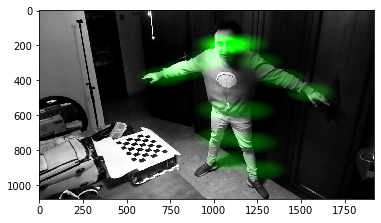

In [144]:

#im_rgb = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
plt.imshow(output_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 80.7218462228775
(1573, 461)


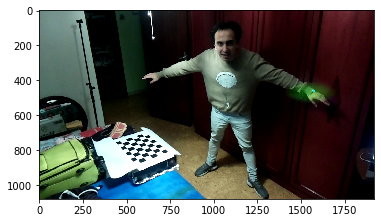

In [145]:
#dibujar articulacion
art=9

artLayer=processed_output[art]
print(artLayer.min(), artLayer.max())
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(artLayer)
print(max_loc)

imout= np.zeros(image.shape)
imout[:,:,1]=artLayer
cv2.circle(imout, max_loc, 3, (0, 200, 200), 5)

imout=imout.astype(int)+cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#image.astype(int)
plt.imshow(imout)

In [146]:
# dibujar skeleton

joints, height, width = processed_output.shape

# initialize dataframe of body parts
ixn=['head','left_eye','right_eye','left_ear','right_ear','left_shoulder','right_shoulder','left_elbow',
    'right_elbow','left_wrist', 'right_wrist','left_hip', 'right_hip','left_knee','right_knee', 
    'left_foot', 'right_foot' ]
skeleton=pd.DataFrame(np.zeros((17,2), dtype=np.intc), index=ixn, columns=['x_max','y_max'])
points=[]
for p in range(17):
    points.append((0,0))
skeleton['pt_max'] = pd.Series(points, index=max1d.index)
for bodyPart in range(joints):
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(processed_output[bodyPart])
    skeleton.iloc[bodyPart] = [max_loc[0], max_loc[1], max_loc]

max1d=skeleton['pt_max']
max1d

head              (1093, 213)
left_eye          (1146, 191)
right_eye         (1040, 191)
left_ear          (1199, 191)
right_ear         (1039, 191)
left_shoulder     (1253, 303)
right_shoulder     (986, 281)
left_elbow        (1412, 393)
right_elbow        (826, 348)
left_wrist        (1573, 461)
right_wrist        (719, 371)
left_hip          (1200, 573)
right_hip         (1039, 573)
left_knee         (1200, 753)
right_knee        (1039, 731)
left_foot         (1253, 911)
right_foot        (1093, 866)
Name: pt_max, dtype: object

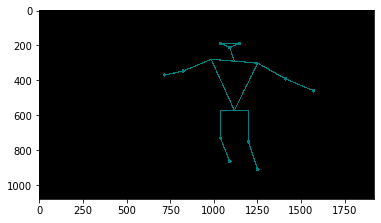

In [148]:

def calcMiddlePoint(p1, p2):
    x1,y1=p1
    x2,y2=p2
    return (min(x1,x2)+int(abs(x2-x1)/2), min(y1,y2)+int(abs(y2-y1)/2))
def calcDistance(p1, p2):
    x1,y1=p1
    x2,y2=p2
    return (int(abs(x2-x1))**2 + int(abs(y2-y1))**2)**0.5

imout = np.zeros(image.shape, dtype=np.int8)

if not(max1d.loc['right_eye']==(0,0) or max1d.loc['left_eye']==(0,0)):
    cv2.line(imout, max1d.loc['right_eye'], max1d.loc['left_eye'], (0, 200, 200),5)
    cv2.circle(imout, max1d.loc['right_eye'], 7, (0, 200, 200),5)
    cv2.circle(imout, max1d.loc['left_eye'], 7, (0, 200, 200),5)
    if (max1d.loc['head']!=(0,0)):
        cv2.line(imout, max1d.loc['right_eye'], max1d.loc['head'], (0, 200, 200),5)
        cv2.line(imout, max1d.loc['left_eye'], max1d.loc['head'], (0, 200, 200),5)

if (max1d.loc['head']!=(0,0)):
    cv2.circle(imout, max1d.loc['head'], 7, (0, 200, 200),5)
    
pelvis=(0,0)
if not(max1d.loc['left_hip']==(0,0) or max1d.loc['right_hip']==(0,0)):
    pelvis = calcMiddlePoint(max1d.loc['left_hip'],max1d.loc['right_hip'])
    cv2.line(imout, max1d.loc['left_hip'], max1d.loc['right_hip'], (0, 200, 200),5)

#headRad=int(calcDistance(max1d.loc['left_shoulder'],max1d.loc['right_shoulder'])/4)+3
if not(max1d.loc['left_shoulder']==(0,0) or max1d.loc['right_shoulder']==(0,0)):
    cv2.line(imout, max1d.loc['left_shoulder'], max1d.loc['right_shoulder'], (0, 200, 200),5)
    neck = calcMiddlePoint(max1d.loc['left_shoulder'],max1d.loc['right_shoulder'])
    if (max1d.loc['head']!=(0,0)):
        cv2.line(imout, max1d.loc['head'], neck, (0, 200, 200),5)
    if (pelvis!=(0,0)):
        cv2.line(imout, pelvis, max1d.loc['left_shoulder'], (0, 200, 200),5)
        cv2.line(imout, pelvis, max1d.loc['right_shoulder'], (0, 200, 200),5)

if (max1d.loc['left_wrist']!=(0,0)):
    cv2.circle(imout, max1d.loc['left_wrist'], 7, (0, 200, 200),5)
    if (max1d.loc['left_elbow']!=(0,0)):
        cv2.line(imout, max1d.loc['left_elbow'], max1d.loc['left_wrist'], (0, 200, 200),5)
        cv2.circle(imout, max1d.loc['left_elbow'], 7, (0, 200, 200),5)
if not(max1d.loc['left_shoulder']==(0,0) or max1d.loc['left_elbow']==(0,0)):
    cv2.line(imout, max1d.loc['left_shoulder'], max1d.loc['left_elbow'], (0, 200, 200),5)

if (max1d.loc['right_wrist']!=(0,0)):
    cv2.circle(imout, max1d.loc['right_wrist'], 7, (0, 200, 200),5)
    if (max1d.loc['right_elbow']!=(0,0)):
        cv2.line(imout, max1d.loc['right_elbow'], max1d.loc['right_wrist'], (0, 200, 200),5)
        cv2.circle(imout, max1d.loc['right_elbow'], 7, (0, 200, 200),5)
if not(max1d.loc['right_shoulder']==(0,0) or max1d.loc['right_elbow']==(0,0)):
    cv2.line(imout, max1d.loc['right_shoulder'], max1d.loc['right_elbow'], (0, 200, 200),5)

if (max1d.loc['left_foot']!=(0,0)):
    cv2.circle(imout, max1d.loc['left_foot'], 7, (0, 200, 200),5)
    if (max1d.loc['left_knee']!=(0,0)):
        cv2.line(imout, max1d.loc['left_knee'], max1d.loc['left_foot'], (0, 200, 200),5)
        cv2.circle(imout, max1d.loc['left_knee'], 7, (0, 200, 200),5)
if not(max1d.loc['left_hip']==(0,0) or max1d.loc['left_knee']==(0,0)):
    cv2.line(imout, max1d.loc['left_hip'], max1d.loc['left_knee'], (0, 200, 200),5)        

if (max1d.loc['right_foot']!=(0,0)):
    cv2.circle(imout, max1d.loc['right_foot'], 7, (0, 200, 200),5)
    if (max1d.loc['right_knee']!=(0,0)):
        cv2.line(imout, max1d.loc['right_knee'], max1d.loc['right_foot'], (0, 200, 200),5)
        cv2.circle(imout, max1d.loc['right_knee'], 7, (0, 200, 200),5)
if not(max1d.loc['right_hip']==(0,0) or max1d.loc['right_knee']==(0,0)):
    cv2.line(imout, max1d.loc['right_hip'], max1d.loc['right_knee'], (0, 200, 200),5)


plt.imshow(imout)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


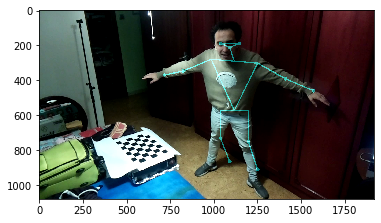

In [149]:

#imout=cv2.add(imout, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), dtype=np.int8)
imout=imout + cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(imout)


In [229]:
mi=np.zeros((16,2))

In [288]:
tuple(max1d.loc['left_shoulder'])

(1253.0, 303.0)

In [289]:
tuple(max1d.loc['left_elbow'])

(1412.0, 393.0)

In [243]:
skeleton.iloc[3,0:2]=(3,2)
skeleton

,x_max,y_max
head,0.0,0.0
left_eye,0.0,0.0
right_eye,0.0,0.0
left_ear,3.0,2.0
right_ear,0.0,0.0
left_shoulder,0.0,0.0
right_shoulder,0.0,0.0
left_elbow,0.0,0.0
right_elbow,0.0,0.0
left_hand,0.0,0.0


In [244]:
skeleton[['x_max']]

,x_max
head,0.0
left_eye,0.0
right_eye,0.0
left_ear,3.0
right_ear,0.0
left_shoulder,0.0
right_shoulder,0.0
left_elbow,0.0
right_elbow,0.0
left_hand,0.0


In [252]:
skeleton.loc['left_ear'][['x_max']]
#skeleton.loc['left_ear'][['x_max']].to_numpy()

x_max    1199.0
Name: left_ear, dtype: float64

In [256]:
skeleton.loc['left_ear'].to_numpy()

array([1199.,  191.])

In [110]:
max1d.iloc[0, 2][1] #= {(1,1)}

0

In [117]:
max1d.loc['right_eye']

(0, 0)

In [114]:
max1d.loc['right_eye'],1

(x_max            704
 y_max            209
 pt_max    (704, 209)
 Name: right_eye, dtype: object,
 1)

In [298]:
tuple(max1d.loc['left_shoulder']) - tuple(max1d.loc['right_shoulder'])

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [20]:
x1,y1=tuple(max1d.loc['left_shoulder'])
x2,y2=tuple(max1d.loc['right_shoulder'])
neck=(min(x1,x2)+abs(x2-x1), min(y1,y2)+abs(y2-y1))


(1253, 303)

In [32]:
def calcDistance(p1, p2):
    x1,y1=p1
    x2,y2=p2
    return (int(abs(x2-x1))**2 + int(abs(y2-y1))**2)**0.5

In [83]:
#tuple(max1d)
points=[]
for p in range(4):
    points.append((0,0))
points

[(0, 0), (0, 0), (0, 0), (0, 0)]